# **UNET - Breast Cancer Detection**

## Import Dependencies

In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd
import tensorflow as tf


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.python.keras import losses

from keras.models import Model, load_model
from keras.optimizers import Adam


Data: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset

In [2]:
image_height = 256
image_width = 256
dpath = "Dataset_BUSI_with_GT"
classes = ['benign', 'malignant', 'normal']

In [3]:
data = {'image' : [],
        'mask' : []}

In [4]:
def load_data(path, data_obj, class_name):
    img_names_list = os.listdir(path+ "/"+class_name)
    image_names = []
    mask_names = []
    names_truncated = []
    
    for i in range(len(img_names_list)):
        names_truncated.append(img_names_list[i].split(')')[0])
    
    names_truncated = list(set(names_truncated))
    
    for i in range(len(names_truncated)):
        image_names.append(names_truncated[i]+').png')
        mask_names.append(names_truncated[i]+')_mask.png')
    
    data_obj = preprocess_data(image_names, mask_names, image_width, image_height, path, class_name, data_obj)
        
        
    return data_obj

In [5]:
def preprocess_data(image_names, mask_names, img_width, img_height, dpath, dclass, data_obj):
    for index in range (len(image_names)):
        image_path = dpath+'/'+dclass+ '/'+ image_names[index]
        mask_path = dpath+'/'+dclass+ '/'+ mask_names[index]
        
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = cv2.resize(x, (image_height, image_width))
        y = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        y = cv2.resize(y, (image_height, image_width))

        x= x/255.0
        y= y/255.0
        data_obj['image'].append(x)
        data_obj['mask'].append(y)

    return data_obj

In [6]:
data = load_data(dpath, data, classes[0]) 
ln = len(data['image'])
print("Number of benign tumor images", ln)
data = load_data(dpath, data, classes[1]) 
print("Number of malignant tumor images", len(data['image'])-ln)
print("Total images for segmentation", len(data['image']))

Number of benign tumor images 437
Number of malignant tumor images 210
Total images for segmentation 647


In [7]:
data['image'] = np.array(data['image'])
data['image'].shape

(647, 256, 256, 3)

In [8]:
data['mask'] = np.array(data['mask'])
data['mask'] =  np.expand_dims(data['mask'], -1)
data['mask'].shape

(647, 256, 256, 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data['image'], data['mask'], test_size=0.2, random_state=42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

517 517 130 130


In [10]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [11]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [12]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

## Model Building 

In [13]:
def build_model(input_layer):
    conv1 = Conv2D(16, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(16, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    drop1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(32, (3, 3), activation="relu", padding="same")(drop1)
    conv2 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    drop2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(64, (3, 3), activation="relu", padding="same")(drop2)
    conv3 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    drop3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(128, (3, 3), activation="relu", padding="same")(drop3)
    conv4 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    drop4 = Dropout(0.5)(pool4)

    conv_middle = Conv2D(256, (3, 3), activation="relu", padding="same")(drop4)
    conv_middle = Conv2D(256, (3, 3), activation="relu", padding="same")(conv_middle)

    deconv4 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(conv_middle)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(128, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(128, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(64, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(64, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(32, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(32, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(16, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(16, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [14]:
input_layer = Input((image_height, image_width, 3))
output_layer = build_model(input_layer)

In [15]:
model = Model(input_layer, output_layer)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [17]:
model.compile(optimizer=Adam(),
                  loss= bce_dice_loss,
                  metrics=[dice_loss, dice_coeff, 'accuracy'])

### Reduce LR

In [18]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
batch_size = 32
epochs = 10

In [20]:
history = model.fit(X_train,y_train,batch_size=batch_size, 
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs, 
                    callbacks=[learning_rate_reduction],
                    validation_split=0.1,
                    verbose = 1)

Epoch 1/10
16/16 [==============================] - 22s 618ms/step - loss: 1.3855 - dice_loss: 0.8593 - dice_coeff: 0.1407 - accuracy: 0.8946 - val_loss: 1.2221 - val_dice_loss: 0.8501 - val_dice_coeff: 0.1499 - val_accuracy: 0.9005 - lr: 0.0010
Epoch 2/10
16/16 [==============================] - 4s 269ms/step - loss: 1.2053 - dice_loss: 0.8730 - dice_coeff: 0.1270 - accuracy: 0.9063 - val_loss: 1.2000 - val_dice_loss: 0.8580 - val_dice_coeff: 0.1420 - val_accuracy: 0.9005 - lr: 0.0010
Epoch 3/10
16/16 [==============================] - 4s 269ms/step - loss: 1.1887 - dice_loss: 0.8720 - dice_coeff: 0.1280 - accuracy: 0.9103 - val_loss: 1.1970 - val_dice_loss: 0.8643 - val_dice_coeff: 0.1357 - val_accuracy: 0.9005 - lr: 0.0010
Epoch 4/10
16/16 [==============================] - ETA: 0s - loss: 1.1891 - dice_loss: 0.8645 - dice_coeff: 0.1355 - accuracy: 0.9043
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 [==============================] - 4s 270ms/ste

## Accuracy

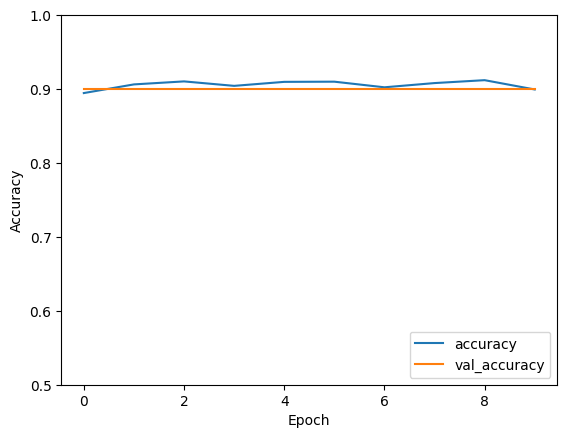

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right');

In [22]:
# Evaluate the model.
score = model.evaluate(X_test, y_test, verbose=0, batch_size = 32)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1836429834365845
Test accuracy: 0.8635609149932861


## Predictions

In [23]:
def predict(image_index):
  fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))
  ax1.imshow(X_test[image_index])
  ax1.set_title("Original Image")
  ax2.imshow(y_test[image_index])
  ax2.set_title("Original Label")
  ax3.imshow(model.predict(X_test[image_index].reshape(1,256,256,3))[0])
  ax3.set_title("Predicted Label")
  plt.show()

1/1 [==============================] - 1s 626ms/step


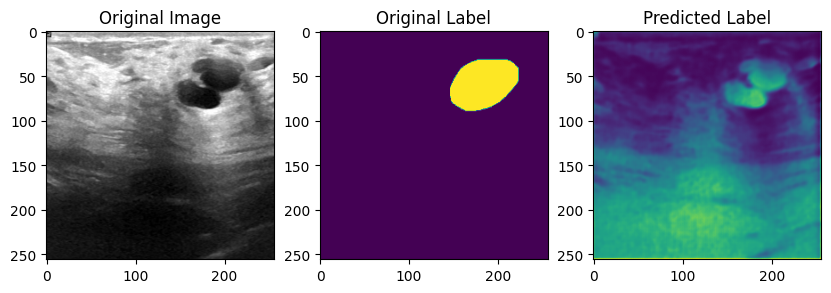

In [24]:
predict(8)

1/1 [==============================] - 0s 18ms/step


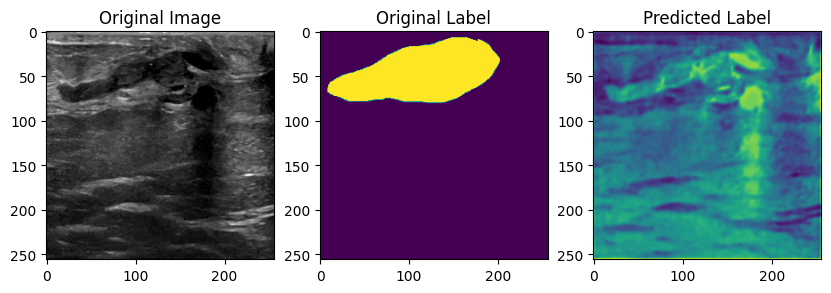

In [25]:
predict(25)

1/1 [==============================] - 0s 20ms/step


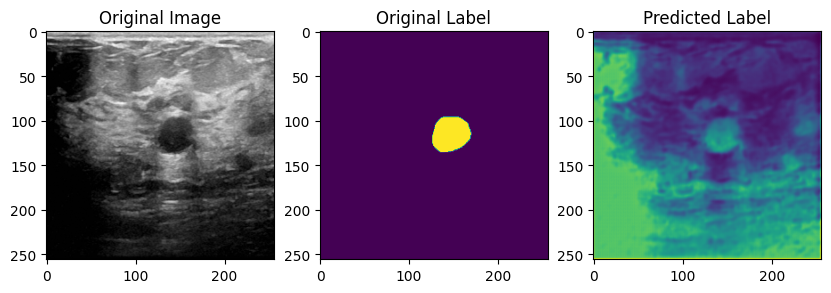

In [26]:
predict(85)